In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("test_pyspark") \
    .config("spark.driver.memory", "100g") \
    .config("spark.executor.memory", "100g") \
    .config("spark.sql.orc.enableVectorizedReader", "false") \
    .config("spark.sql.parquet.columnarReaderBatchSize", "256") \
    .config("spark.sql.orc.columnarReaderBatchSize", "256") \
    .getOrCreate()

spark.sparkContext.setLogLevel("ERROR")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/21 14:13:12 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/05/21 14:13:12 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [ ]:
#spark.stop()

In [2]:
spark.table("iiif_manifests").count()

339927

In [3]:
spark.table("iiif_manifests").printSchema()

root
 |-- @context: string (nullable = true)
 |-- @id: string (nullable = true)
 |-- @type: string (nullable = true)
 |-- behavior: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- collections: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- @id: string (nullable = true)
 |    |    |-- @type: string (nullable = true)
 |    |    |-- label: string (nullable = true)
 |    |    |-- manifests: array (nullable = true)
 |    |    |    |-- element: struct (containsNull = true)
 |    |    |    |    |-- @id: string (nullable = true)
 |    |    |    |    |-- @type: string (nullable = true)
 |    |    |    |    |-- label: string (nullable = true)
 |    |    |    |    |-- thumbnail: struct (nullable = true)
 |    |    |    |    |    |-- @id: string (nullable = true)
 |    |    |    |    |    |-- @type: string (nullable = true)
 |    |    |    |    |    |-- service: struct (nullable = true)
 |    |    |    |    |    |    |-- @context

In [48]:
df = spark.table("iiif_manifests")

In [49]:
df.select("manifest_id", "id").sample(False, 0.01).show(5, False)

+-----------+--------+
|manifest_id|id      |
+-----------+--------+
|b2001594x  |g8sbx8t5|
|b21693985  |k94y94k5|
|b21713819  |kjp78bpt|
|b32781416  |qy66mr55|
|b24865254  |wbee35jr|
+-----------+--------+
only showing top 5 rows



In [50]:
from pyspark.sql import functions as F
from pyspark.sql.types import ArrayType, StructType, StructField, StringType

# Define the target schema
json_schema = ArrayType(
    StructType([
        StructField("@id", StringType(), True),
        StructField("label", StringType(), True),
        StructField("format", StringType(), True),
    ])
)

df_flat = (df
#   .where(df.manifest_id == "b30857892")
  .withColumn("seq", F.explode("sequences").alias("seq"))
  .withColumn("rendering_structured", F.from_json(F.col("seq.rendering"), json_schema))
  .select("id", "rendering_structured")
)

In [51]:
df_flat.limit(5).show(truncate=False)

+--------+-----------------------------------------------------------------------------------+
|id      |rendering_structured                                                               |
+--------+-----------------------------------------------------------------------------------+
|s2e7xwse|[{https://iiif.wellcomecollection.org/pdf/b24963215, View as PDF, application/pdf}]|
|ajzbvepw|[{https://iiif.wellcomecollection.org/pdf/b24937435, View as PDF, application/pdf}]|
|ej6rs4hu|[{https://iiif.wellcomecollection.org/pdf/b24947866, View as PDF, application/pdf}]|
|anzq3zmz|[{https://iiif.wellcomecollection.org/pdf/b24937800, View as PDF, application/pdf}]|
|uzdd3jaj|[{https://iiif.wellcomecollection.org/pdf/b24945390, View as PDF, application/pdf}]|
+--------+-----------------------------------------------------------------------------------+



In [60]:
# Explode rendering structured and where rows with format = "text/plain"

df_flat_exploded = (df_flat
  .withColumn("rendering_structured", F.explode("rendering_structured"))
  .where(F.col("rendering_structured.format") == "text/plain")
#   .select("id", F.col("rendering_structured.@id").alias("raw_text_url"))
)
df_flat_exploded.limit(5).show(truncate=False)

+--------+---------------------------------------------------------------------------------+
|id      |rendering_structured                                                             |
+--------+---------------------------------------------------------------------------------+
|vv8zk4pe|{https://api.wellcomecollection.org/text/v1/b31983054, View raw text, text/plain}|
|nrec4k8a|{https://api.wellcomecollection.org/text/v1/b21507570, View raw text, text/plain}|
|gz39d4h5|{https://api.wellcomecollection.org/text/v1/b24883797, View raw text, text/plain}|
|ux5aqqvv|{https://api.wellcomecollection.org/text/v1/b21530105, View raw text, text/plain}|
|kjykxv92|{https://api.wellcomecollection.org/text/v1/b32816509, View raw text, text/plain}|
+--------+---------------------------------------------------------------------------------+



# Histogram of number of text/plain renderings

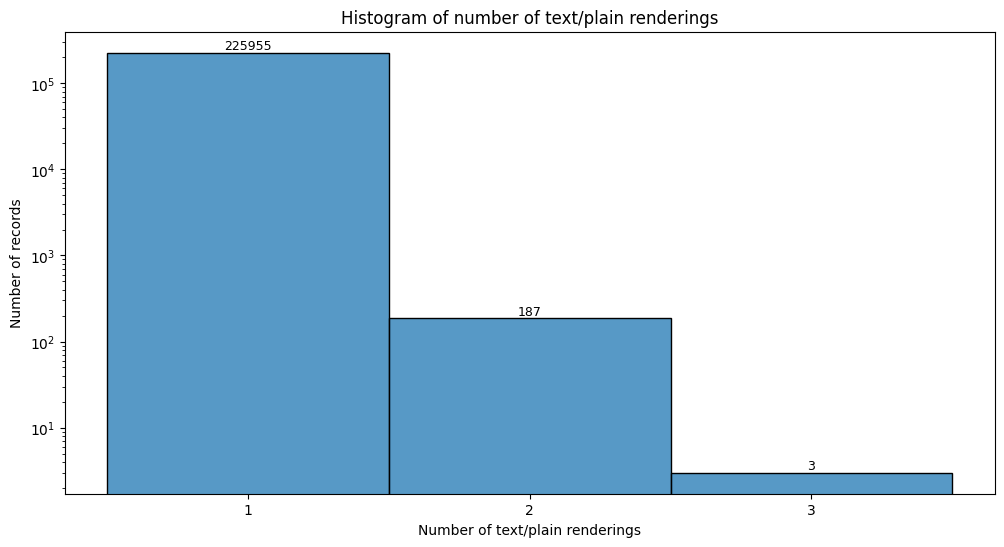

In [56]:
# Make histogram of number of text/plain renderings
df_flat_exploded_counts = (
    df_flat_exploded.groupBy("id")
    .agg(F.count("*").alias("count"))
)
df_flat_exploded_counts.createOrReplaceTempView("df_flat_exploded_counts")

# Plot histogram
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

df_flat_exploded_counts_pd = df_flat_exploded_counts.toPandas()
df_flat_exploded_counts_pd = df_flat_exploded_counts_pd.sort_values("count", ascending=False)

plt.figure(figsize=(12, 6))
ax = sns.histplot(
    df_flat_exploded_counts_pd, 
    x="count", 
    bins=range(df_flat_exploded_counts_pd["count"].min(), df_flat_exploded_counts_pd["count"].max() + 2), # bin edges for discrete ints
    discrete=True
)
# plt.xscale("log")
plt.yscale("log")
plt.xlabel("Number of text/plain renderings")
plt.ylabel("Number of records")
plt.title("Histogram of number of text/plain renderings")
plt.xticks(
    ticks=range(
        int(df_flat_exploded_counts_pd["count"].min()), 
        int(df_flat_exploded_counts_pd["count"].max()) + 1
    )
)

# Add number to each bar
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.annotate(
            f"{int(height)}",
            (p.get_x() + p.get_width() / 2, height),
            ha="center", va="bottom", fontsize=9, rotation=0
        )

# plt.savefig("histogram_text_plain_renderings.png")
plt.show()

# Investigate works with > 1 text/plain renderings

In [65]:
# select df_flat_exploded with rendering_structured array len == 2
df_flat_exploded_2 = (
    (
        df_flat_exploded_counts
        .where(F.col("count") == 2)
    )
    .join(df_flat_exploded, on="id", how="left")
)
df_flat_exploded_2.show(truncate=False)

+--------+-----+---------------------------------------------------------------------------------+
|id      |count|rendering_structured                                                             |
+--------+-----+---------------------------------------------------------------------------------+
|ab4znv6h|2    |{https://api.wellcomecollection.org/text/v1/b28101807, View raw text, text/plain}|
|ab4znv6h|2    |{https://api.wellcomecollection.org/text/v1/b20444400, View raw text, text/plain}|
|bwhgcq75|2    |{https://api.wellcomecollection.org/text/v1/b28106027, View raw text, text/plain}|
|bwhgcq75|2    |{https://api.wellcomecollection.org/text/v1/b18028986, View raw text, text/plain}|
|c4cacmvu|2    |{https://api.wellcomecollection.org/text/v1/b20457807, View raw text, text/plain}|
|c4cacmvu|2    |{https://api.wellcomecollection.org/text/v1/b29008980, View raw text, text/plain}|
|dnxhwn3k|2    |{https://api.wellcomecollection.org/text/v1/b28083222, View raw text, text/plain}|
|dnxhwn3k|

## Findings

Sorting the @id descending and taking the first appears to select the most recent OCR

In [78]:
# Filter by rendering_structured.format == "text/plain" and Sort by rendering_structured.@id and
# take first

df_flat_first_only = (
    df_flat
    .withColumn("rendering_structured", F.explode("rendering_structured"))
    .where(F.col("rendering_structured.format") == "text/plain")
    .groupBy("id")
    .agg(F.collect_list("rendering_structured").alias("rendering_structured"))
    .withColumn("rendering_structured", F.sort_array(F.col("rendering_structured.@id")))
    .withColumn("raw_text_url", F.col("rendering_structured")[0])
    .select("id", "raw_text_url")
)

In [79]:
df_flat_first_only.show(truncate=False)

+--------+----------------------------------------------------+
|id      |raw_text_url                                        |
+--------+----------------------------------------------------+
|a22g3y27|https://api.wellcomecollection.org/text/v1/b21466439|
|a23upgqy|https://api.wellcomecollection.org/text/v1/b30758762|
|a23urqkp|https://api.wellcomecollection.org/text/v1/b31689929|
|a24fw5jd|https://api.wellcomecollection.org/text/v1/b29734666|
|a24mbtch|https://api.wellcomecollection.org/text/v1/b19954153|
|a24qme7r|https://api.wellcomecollection.org/text/v1/b30334330|
|a24wuvs5|https://api.wellcomecollection.org/text/v1/b31652220|
|a25aqhgm|https://api.wellcomecollection.org/text/v1/b20995738|
|a264n73x|https://api.wellcomecollection.org/text/v1/b30501477|
|a26g2q4s|https://api.wellcomecollection.org/text/v1/b21900905|
|a279rqmt|https://api.wellcomecollection.org/text/v1/b30150024|
|a28zunh5|https://api.wellcomecollection.org/text/v1/b30798644|
|a29fqnhx|https://api.wellcomecollection

In [70]:
df_flat_exploded_counts_pd.shape[0]

226145

In [83]:
df_flat_first_only.count()

226145

In [84]:
assert(df_flat_first_only.count() == df_flat_exploded_counts_pd.shape[0])

# Fetch Texts

In [93]:
import requests
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType, StructType, StructField

# Define UDF to download text and return (text, status)
def fetch_text(url):
    if not url:
        return ("", "empty_url")
    try:
        resp = requests.get(url, timeout=10)
        if resp.status_code == 200:
            return (resp.text, "success")
        elif resp.status_code == 404:
            return ("", "not_found")
        else:
            return ("", f"status_{resp.status_code}")
    except Exception as e:
        return ("", "error")

fetch_text_udf = udf(fetch_text, StructType([
    StructField("text", StringType(), True),
    StructField("download_status", StringType(), True)
]))

df_flat_first_only_with_text = (
    df_flat_first_only.sample(False, 0.01)
    .withColumn("fetch_result", fetch_text_udf("raw_text_url"))
    .withColumn("text", F.col("fetch_result.text"))
    .withColumn("download_status", F.col("fetch_result.download_status"))
    .drop("fetch_result")
)

df_flat_first_only_with_text.show(5, truncate=100)

+--------+----------------------------------------------------+----------------------------------------------------------------------------------------------------+---------------+
|      id|                                        raw_text_url|                                                                                                text|download_status|
+--------+----------------------------------------------------+----------------------------------------------------------------------------------------------------+---------------+
|a5hatug3|https://api.wellcomecollection.org/text/v1/b21530907|The University Library Leeds â ââ LEEDS UNIVERSITY LIBRARY Classmark: (My 3 0106 01121 9903...|        success|
|a6s7xqhv|https://api.wellcomecollection.org/text/v1/b20391523|0' 0' <X>CXXX>0<><>0<X><><>0<><>^ NEW GUIDE FOR THE Hotel, Bar, Restaurant, Butler, AND Chef. I F...|        success|
|abwuqthn|https://api.wellcomecollection.org/text/v1/b33098268|Lh i 1 ie Ie Reo ae ont a Benet 

# Run iiif_manifests.py to download all text

```log
python src/wc_simd/iiif_manifests.py create_plain_text_rendering_parquet --output_parquet ./data/plain_text_rendering.parquet
INFO:root:Creating plain text rendering parquet ./data/plain_text_rendering.parquet...
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/21 14:52:04 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
INFO:root:Time taken: 2289.24 seconds
INFO:py4j.clientserver:Closing down clientserver connection
```

In [15]:
# Get size of parquet dir
import os

def get_dir_size(path):
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(path):
        for f in filenames:
            fp = os.path.join(dirpath, f)
            total_size += os.path.getsize(fp)
    return total_size

parquet_dir = "../data/plain_text_rendering.parquet"
parquet_dir_size = get_dir_size(parquet_dir)
print(f"Parquet dir size: {parquet_dir_size / (1024 * 1024 * 1024):.2f} GB")

Parquet dir size: 32.95 GB
